In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import numpy as np
from matplotlib import animation
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as cols
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap
from matplotlib import ticker, cm
import seaborn as sns
import xarray as xr
import xgcm
import pop_tools

In [2]:
data222=nc.Dataset("/work/DXL/xiliangdiao/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0490-09.nc")
TLONG222 = data222.variables['TLONG'][:480,:]
TLAT222 = data222.variables['TLAT'][:480,:]
TLONG222[TLONG222==-1] = np.nan
TLAT222[TLAT222==-1] = np.nan
ULONG222 = data222.variables['ULONG'][:480,:]
ULAT222 = data222.variables['ULAT'][:480,:]
ULONG222[ULONG222==-1] = np.nan
ULAT222[ULAT222==-1] = np.nan

UET = data222.variables['UET'][:480,:]
VNT = data222.variables['VNT'][:480,:]

In [3]:
data222=xr.open_dataset("/work/DXL/xiliangdiao/B.E.13.B1850C5.ne120_t12.sehires38.003.sunway_02.pop.h.0490-09.nc")
VVEL = data222['VVEL'][0,:,:]
KMU= data222['KMU'][:480,:] ## k Index of Deepest Grid Cell on U Grid
HU= data222['HU'][:480,:]/100 ## water depth on U grid, m
HT= data222['HT'][:,:] ## water depth on T grid, cm
#SSH= data222['SSH'][:,:]
DXU= data222['DXU'][:,:] ## cm
DYT= data222['DYT'][:,:] ## cm

UVEL = data222['UVEL'][0,:,:]
tlat = data222['TLAT'][:,700]
tlon = data222['TLONG'][478,:]

#nlat = data222['nlat']
ulat = data222['ULAT'][:,700]
ulon = data222['ULONG'][478,:]

# ZZZ in m

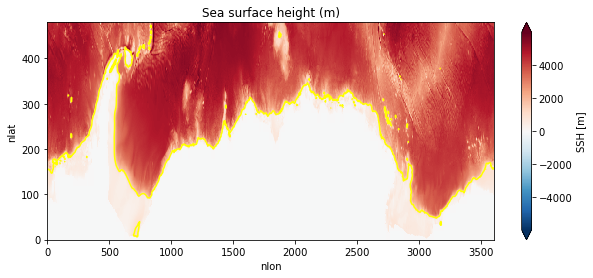

In [4]:
fig = plt.figure(figsize = (10, 4))
HU.plot(extend='both', cbar_kwargs={'label': "SSH [m]"})
HU.plot.contour(levels = [1000],colors = 'yellow', linestyles = '-')
plt.title('Sea surface height (m)');

In [5]:
# Fill in land with zeros:
HU = HU.fillna(0)

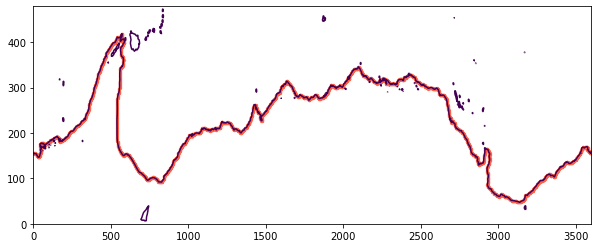

In [6]:
fig = plt.figure(figsize = (10, 4))
count = 0
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(HU, levels=[1000])
for collection in sc.collections:
    for path in collection.get_paths():
        #print(path)
        count += 1
        #print(count)
        if count ==  1:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

In [7]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [8]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [9]:
HU_contour = np.zeros(len(x_contour))

for ii in range(len(HU_contour)):
    HU_contour[ii] = HU[y_contour[ii], x_contour[ii]]

In [10]:
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(HU_contour)):
    lon_along_contour[ii] = tlon[x_contour[ii]]
    lat_along_contour[ii] = tlat[y_contour[ii]]

In [11]:
lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

In [12]:
# Number of grid points on the contour
num_points = len(lat_along_contour)

In [13]:
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

In [14]:
contour_mask = HU*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

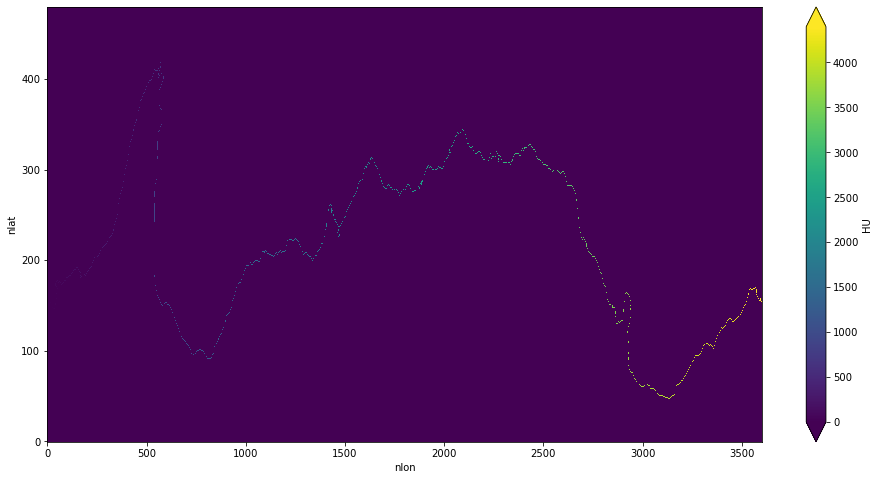

In [15]:
plt.figure(1, figsize=(16, 8))
contour_mask.plot(extend='both');

In [16]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value


# from top left:
for ii in range(len(TLAT222[1])-1):
    for jj in range(len(TLONG222))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(TLAT222[1]))[::-1][:-1]:
    for jj in range(len(TLONG222))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(TLAT222[1]))[::-1][:-1]:
    for jj in range(len(TLONG222)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(TLAT222[1])-1):
    for jj in range(len(TLONG222)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

In [17]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

mask_y_transport_loc1 = []
mask_y_transport_loc2 = []
mask_x_transport_loc1 = []
mask_x_transport_loc2 = []



# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        #mask_y_transport_loc1.append(tlat[index_j])
        #mask_y_transport_loc2.append(tlon[index_i])
        # important to do
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        #mask_y_transport_loc1.append(tlat[index_j-1])
        #mask_y_transport_loc2.append(tlon[index_i])
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
        
        # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        #mask_y_transport_loc1.append(tlat[index_j-1])
        #mask_y_transport_loc2.append(tlon[index_i])
        
        mask_y_transport[index_j, index_i] = -1
        #mask_y_transport_loc1.append(tlat[index_j])
        #mask_y_transport_loc2.append(tlon[index_i])
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        #mask_x_transport_loc1.append(tlat[index_j])
        #mask_x_transport_loc2.append(tlon[index_i])
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        #mask_x_transport_loc1.append(tlat[index_j])
        #mask_x_transport_loc2.append(tlon[index_i-1])
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        #mask_x_transport_loc1.append(tlat[index_j])
        #mask_x_transport_loc2.append(tlon[index_i-1])
        
        mask_x_transport[index_j, index_i] = -1
        #mask_x_transport_loc1.append(tlat[index_j])
        #mask_x_transport_loc2.append(tlon[index_i])
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

/home/dxl/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/dxl/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/dxl/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/dxl/.conda/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will re

In [18]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.

mask_x_transport = xr.DataArray(mask_x_transport, coords = [tlat[:480], ulon], dims = ['y_ocean','x_ocean'])
mask_y_transport = xr.DataArray(mask_y_transport, coords = [ulat[:480],tlon], dims = ['y_ocean','x_ocean'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [tlat[:480], ulon], dims = ['y_ocean','x_ocean'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [ulat[:480], tlon], dims = ['y_ocean','x_ocean'])

In [19]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d2 = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d2.where(mask_x_numbered_1d2 > 0, drop = True)

mask_y_numbered_1d2 = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d2.where(mask_y_numbered_1d2 > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [20]:
#data123 = np.load('/home/dxl/TRY/speed1850-60.npy')
#U = data123
#V = np.load('/home/dxl/TRY/speed1850-60V.npy')

In [21]:
#U[U>100000]=np.nan
#V[V>100000]=np.nan

In [22]:
#data222['UVEL'][0,:,:480,:] = U[:,:480,:]
#data222['VVEL'][0,:,:480,:] = V[:,:480,:]

In [23]:
# select latitude range:
tx_trans = data222['UVEL'][0,:,:480,:]*data222['DXU'][:480,:]*data222['dz']/1000000  ##unit is m3/s
ty_trans = data222['VVEL'][0,:,:480,:]*data222['DYU'][:480,:]*data222['dz']/1000000 
    
ty_trans = ty_trans.rename({'nlat': 'y_ocean', 'nlon': 'x_ocean'})
tx_trans = tx_trans.rename({'nlat': 'y_ocean', 'nlon': 'x_ocean'})

In [24]:
ρ0 = 1035 # kg/m^3

ty_trans = ty_trans * mask_y_transport / ρ0 # convert to Sv
tx_trans = tx_trans * mask_x_transport / ρ0 # convert to Sv

In [25]:
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_transport_1d = tx_trans.stack(contour_index = ['y_ocean', 'x_ocean'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d2>0, drop = True)
y_transport_1d = ty_trans.stack(contour_index = ['y_ocean', 'x_ocean'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d2>0, drop = True)

In [26]:
# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')

vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array



In [27]:
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.y_ocean
lon_along_contour = contour_ordering.x_ocean

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

In [28]:
from matplotlib import gridspec
import matplotlib.colors as col
import matplotlib.path as mpath

In [29]:
isobath_ordering  =contour_ordering
#### GET LAT AND LON ALONG ISOBATH
## since the metadata is retain it is incredibly easy to extract lat/lon along isobath
lat_along_isobath = isobath_ordering.y_ocean
lon_along_isobath = isobath_ordering.x_ocean
#isobath_index_array = np.arange(1,6003)

In [30]:
TEMP= data222['TEMP'][0,:,:480,:] ## k Index of Deepest Grid Cell on U Grid
SALT= data222['SALT'][0,:,:480,:] ## water depth on U grid, m
z_t = data222['z_t'][:]/100 ## unit in m

In [31]:
################################
#### GET TEMP ALONG ISOBATH ####
################################
temp_x_transport = xr.DataArray(TEMP, coords = [z_t,tlat[:480], ulon], dims = ['z_t','y_ocean','x_ocean'])
temp_y_transport = xr.DataArray(TEMP, coords = [z_t,ulat[:480],tlon], dims = ['z_t','y_ocean','x_ocean'])


temp_x_transport =temp_x_transport.stack(contour_index = ['y_ocean', 'x_ocean'])
temp_x_transport = temp_x_transport.where(mask_x_numbered_1d2 > 0, drop = True)

temp_y_transport = temp_y_transport.stack(contour_index = ['y_ocean', 'x_ocean'])
temp_y_transport = temp_y_transport.where(mask_y_numbered_1d2 > 0, drop = True)

tempisobath_ordering = xr.concat((temp_x_transport, temp_y_transport), dim = 'contour_index')
tempisobath_ordering = tempisobath_ordering.sortby(isobath_ordering)

In [32]:
################################
#### GET SALT ALONG ISOBATH ####
################################
salt_x_transport = xr.DataArray(SALT, coords = [z_t,tlat[:480], ulon], dims = ['z_t','y_ocean','x_ocean'])
salt_y_transport = xr.DataArray(SALT, coords = [z_t,ulat[:480],tlon], dims = ['z_t','y_ocean','x_ocean'])


salt_x_transport = salt_x_transport.stack(contour_index = ['y_ocean', 'x_ocean'])
salt_x_transport = salt_x_transport.where(mask_x_numbered_1d2 > 0, drop = True)

salt_y_transport = salt_y_transport.stack(contour_index = ['y_ocean', 'x_ocean'])
salt_y_transport = salt_y_transport.where(mask_y_numbered_1d2 > 0, drop = True)

saltisobath_ordering = xr.concat((salt_x_transport, salt_y_transport), dim = 'contour_index')
saltisobath_ordering = saltisobath_ordering.sortby(isobath_ordering)

In [33]:
from gsw import SA_from_SP, p_from_z, CT_from_pt, sigma1
#### CONVERT TEMP/SAL FROM PT/PSU TO CT/AS UNITS
depth = -z_t
depth = xr.DataArray(depth, coords = [z_t], dims = ['z_t'])
depth_along_isobath = (saltisobath_ordering[:,:]*0+1)*depth

print('compute pressure_along_isobath (numpy function)')
#pressure_along_isobath = p_from_z(depth_along_isobath,isobath_ordering)
pressure_along_isobath = xr.DataArray(p_from_z(depth_along_isobath,isobath_ordering), 
                                      coords = [z_t,saltisobath_ordering.contour_index[:]], 
                                      dims = ['z_t','contour_index'], 
                                      name = 'pressure', attrs = {'units':'dbar'})                                   

print('pressure_along_isobath computed')


########### Absolute Salinity from Practical Salinity
#salt_along_isobath = SA_from_SP(saltisobath_ordering,pressure_along_isobath,
                                           # 4,4)
salt_along_isobath = xr.DataArray(SA_from_SP(saltisobath_ordering,pressure_along_isobath,
                                             lon_along_isobath,lat_along_isobath), 
                                  coords = [z_t,saltisobath_ordering.contour_index[:]], 
                                  dims = ['z_t','contour_index'], 
                                  name = 'Absolute salinity', 
                                  attrs = {'units':'Absolute Salinity (g/kg)'})

#ds_salt_along_isobath = xr.Dataset({'salt_along_isobath': salt_along_isobath})
#ds_salt_along_isobath.to_netcdf(save_dir+'salt_along_isobath_AS_9091_65.nc')

#del ds_salt_along_isobath

compute pressure_along_isobath (numpy function)
pressure_along_isobath computed


In [34]:
############# Conservative Temperature from potential temperature
temp_along_isobath = xr.DataArray(CT_from_pt(salt_along_isobath,tempisobath_ordering), 
                                  coords = [z_t,saltisobath_ordering.contour_index[:]], 
                                  dims = ['z_t','contour_index'],  
                                  name = 'Conservative temperature', 
                                  attrs = {'units':'Conservative Temperature (C)'})
ds_temp_along_isobath = xr.Dataset({'_temp_along_isobath': temp_along_isobath})
#ds_temp_along_isobath.to_netcdf(save_dir+'temp_along_isobath_CT_9091_65.nc')

#del ds_temp_along_isobath

print('temp_along_isobath (CT) computed and saved')

temp_along_isobath (CT) computed and saved


In [35]:
sigma1_along_isobath = xr.DataArray(sigma1(salt_along_isobath,temp_along_isobath),
                                     coords = [z_t, saltisobath_ordering.contour_index[:]], 
                                    dims = ['z_t', 'contour_index'], 
                                     name = 'potential density ref 1000dbar', 
                                    attrs = {'units':'kg/m^3 (-1000 kg/m^3)'})

#ds_sigma1_along_isobath = xr.Dataset({'sigma1_along_isobath': sigma1_along_isobath})
#ds_sigma1_along_isobath.to_netcdf(save_dir+'sigma1_along_isobath_9091_65.nc')

#del ds_sigma1_along_isobath, salt_along_isobath, temp_along_isobath

print('sigma1_along_isobath computed')

sigma1_along_isobath computed


In [36]:
sigma1_along_isobath = sigma1_along_isobath.sortby(isobath_ordering)

In [37]:
isopycnal_bins_sigma1 = np.arange(np.nanmin(sigma1_along_isobath),np.nanmax(sigma1_along_isobath)+0.01,0.01)

In [38]:

## intialise empty transport along isobath in density bins array
vol_trans_across_contour = xr.DataArray(vol_trans_across_contour, 
                                               coords = [z_t, saltisobath_ordering.contour_index[:]], 
                                               dims = ['z_t', 'contour_index'], 
                                               name = 'vol_trans_across_contour_binned')

In [40]:
## intialise empty transport along isobath in density bins array
vol_trans_across_isobath_binned = xr.DataArray(np.zeros((len(isopycnal_bins_sigma1),6006)), 
                                               coords = [isopycnal_bins_sigma1, saltisobath_ordering.contour_index[:]], 
                                               dims = ['isopycnal_bins', 'contour_index'], 
                                               name = 'vol_trans_across_contour_binned')

In [41]:
for i in range(len(isopycnal_bins_sigma1)-1):
    bin_mask = sigma1_along_isobath.where(sigma1_along_isobath<=isopycnal_bins_sigma1[i+1]).where(sigma1_along_isobath>isopycnal_bins_sigma1[i])*0+1
    bin_fractions = (isopycnal_bins_sigma1[i+1]-sigma1_along_isobath * bin_mask)/(isopycnal_bins_sigma1[i+1]-isopycnal_bins_sigma1[i])
    ## transport
    vol_trans_across_contour_in_sigmalower_bin = (vol_trans_across_contour * bin_mask * bin_fractions).sum(dim = 'z_t')
    vol_trans_across_isobath_binned[i,:] += vol_trans_across_contour_in_sigmalower_bin.fillna(0)
    #del transport_across_isobath_in_sigmalower_bin
    vol_trans_across_contour_in_sigmaupper_bin = (vol_trans_across_contour * bin_mask * (1-bin_fractions)).sum(dim = 'z_t')
    vol_trans_across_isobath_binned[i+1,:] += vol_trans_across_contour_in_sigmaupper_bin.fillna(0)
    #del bin_mask, bin_fractions, transport_across_isobath_in_sigmaupper_bin
    #print(i)

print('Start vol_trans_across_isobath_binned.load()')

Start vol_trans_across_isobath_binned.load()


In [42]:
net_offshore_trans_8485 = vol_trans_across_isobath_binned.sum('contour_index')
net_offshore_trans_8485 = net_offshore_trans_8485.values
net_offshore_trans_8485 = np.cumsum(net_offshore_trans_8485[::-1])[::-1]* 1e-3

In [43]:
## what are the dense water mass cutoffs?
isopycnal_bins = vol_trans_across_isobath_binned.isopycnal_bins
DSW_8485_density = isopycnal_bins[np.argmax(net_offshore_trans_8485)]
DSW_8485_bin = np.argmax(net_offshore_trans_8485)
print(DSW_8485_density.values)
print(DSW_8485_bin)

32.412492937905455
45


In [44]:
DSW_trans = vol_trans_across_isobath_binned.sel(isopycnal_bins = slice(DSW_8485_density,None)).sum(dim = 'isopycnal_bins').cumsum(dim = 'contour_index').load()/1e3
CDW_trans = vol_trans_across_isobath_binned.sel(isopycnal_bins = slice(32.37,DSW_8485_density)).sum(dim = 'isopycnal_bins').cumsum(dim = 'contour_index').load()/1e3
AASW_trans = vol_trans_across_isobath_binned.sel(isopycnal_bins = slice(None,32.37)).sum(dim = 'isopycnal_bins').cumsum(dim = 'contour_index').load()/1e3
total_trans = vol_trans_across_isobath_binned.sum(dim = 'isopycnal_bins').cumsum(dim = 'contour_index').load()/1e3

In [45]:
DSW_trans2 = vol_trans_across_isobath_binned.sel(isopycnal_bins = slice(DSW_8485_density,None)).sum(dim = 'isopycnal_bins').load()/1e3
CDW_trans2 = vol_trans_across_isobath_binned.sel(isopycnal_bins = slice(32.37,DSW_8485_density)).sum(dim = 'isopycnal_bins').load()/1e3
AASW_trans2 = vol_trans_across_isobath_binned.sel(isopycnal_bins = slice(None,32.37)).sum(dim = 'isopycnal_bins').load()/1e3
total_trans2 = vol_trans_across_isobath_binned.sum(dim = 'isopycnal_bins').load()/1e3

In [46]:
window_size = 50

resultAASW_trans2 = []
for i in range(len(AASW_trans2) - window_size + 1):
    window = AASW_trans2[i : i + window_size]
    window_average = sum(window) / window_size
    resultAASW_trans2.append(window_average)
    
resultCDW_trans2 = []
for i in range(len(CDW_trans2) - window_size + 1):
    window = CDW_trans2[i : i + window_size]
    window_average = sum(window) / window_size
    resultCDW_trans2.append(window_average)
    
resultDSW_trans2 = []
for i in range(len(DSW_trans2) - window_size + 1):
    window = DSW_trans2[i : i + window_size]
    window_average = sum(window) / window_size
    resultDSW_trans2.append(window_average)

In [47]:
def offshore_transport_sum(ax):
    ax.plot(net_offshore_trans_8485,isopycnal_bins_sigma1,color = 'k', linewidth = 2, label = 'Control')
    ax.set_ylabel(r'$\sigma_{1}$ (kg m$^{-3}$)', fontsize = 28)
    ax.set_xlabel(r'Offshore transport (Sv)', fontsize = 28)
    ax.plot([0,0],[30,32.8],'k',linewidth=0.5, alpha = 0.5)
    ax.plot([-2,16],[DSW_8485_density, DSW_8485_density],'k',linewidth=0.5)
    ax.plot([-2,16],[32.37, 32.37],'k',linewidth=0.5)
    #ax.set_xlim((-0.5,11))
    ax.set_ylim((np.nanmax(sigma1_along_isobath)+0.01,np.nanmin(sigma1_along_isobath)))
    ax.set_xticks([0,2,4,6,8,10])
    ax.set_xticklabels([0,2,4,6,8,10],fontsize = 28)
    ax.text(9,32.7, 'DSW', fontsize = 28, color = 'purple')
    ax.text(9,32.45, 'CDW', fontsize = 28, color = 'tomato')    
    ax.text(8.4,32.3, 'AASW', fontsize = 28, color = 'royalblue') 
    #x.set_xticklabels(fontsize = 28)

In [60]:
def offshore_transport(ax):
    #ax.fill_between([698,1850],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)
    #ax.fill_between([3460,4300],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)
    #ax.fill_between([5524,5850],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)

    #ax.plot(total_trans2, color = 'k', linewidth = 1,label = 'Total')
    ax.plot(AASW_trans, color = 'royalblue', linewidth = 2,label = 'AASW')
    ax.plot(CDW_trans, color = 'tomato', linewidth = 2,label = 'CDW')
    ax.plot(DSW_trans, color = 'purple', linewidth = 2,label = 'DSW')

    ax.set_ylabel('Offshore transport (Sv)', fontsize = 28)
    ax.set_xlabel('Isobath Index', fontsize = 28)
    ax.plot([0,contour_index_array[-1]],[0,0],'gray',linewidth=0.5)


    ax.set_xlim((0,contour_index_array[-1]))
    #ax.set_yticks([-8,-6,-4,-2,0,2,4,6,8,10])
    #ax.set_ylim((-8.2,11.2))
    ax.legend(loc=2, fontsize = 24)
    ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
    ax.set_xticklabels(['250','306','348','53','120','184','245'], fontsize = 28)

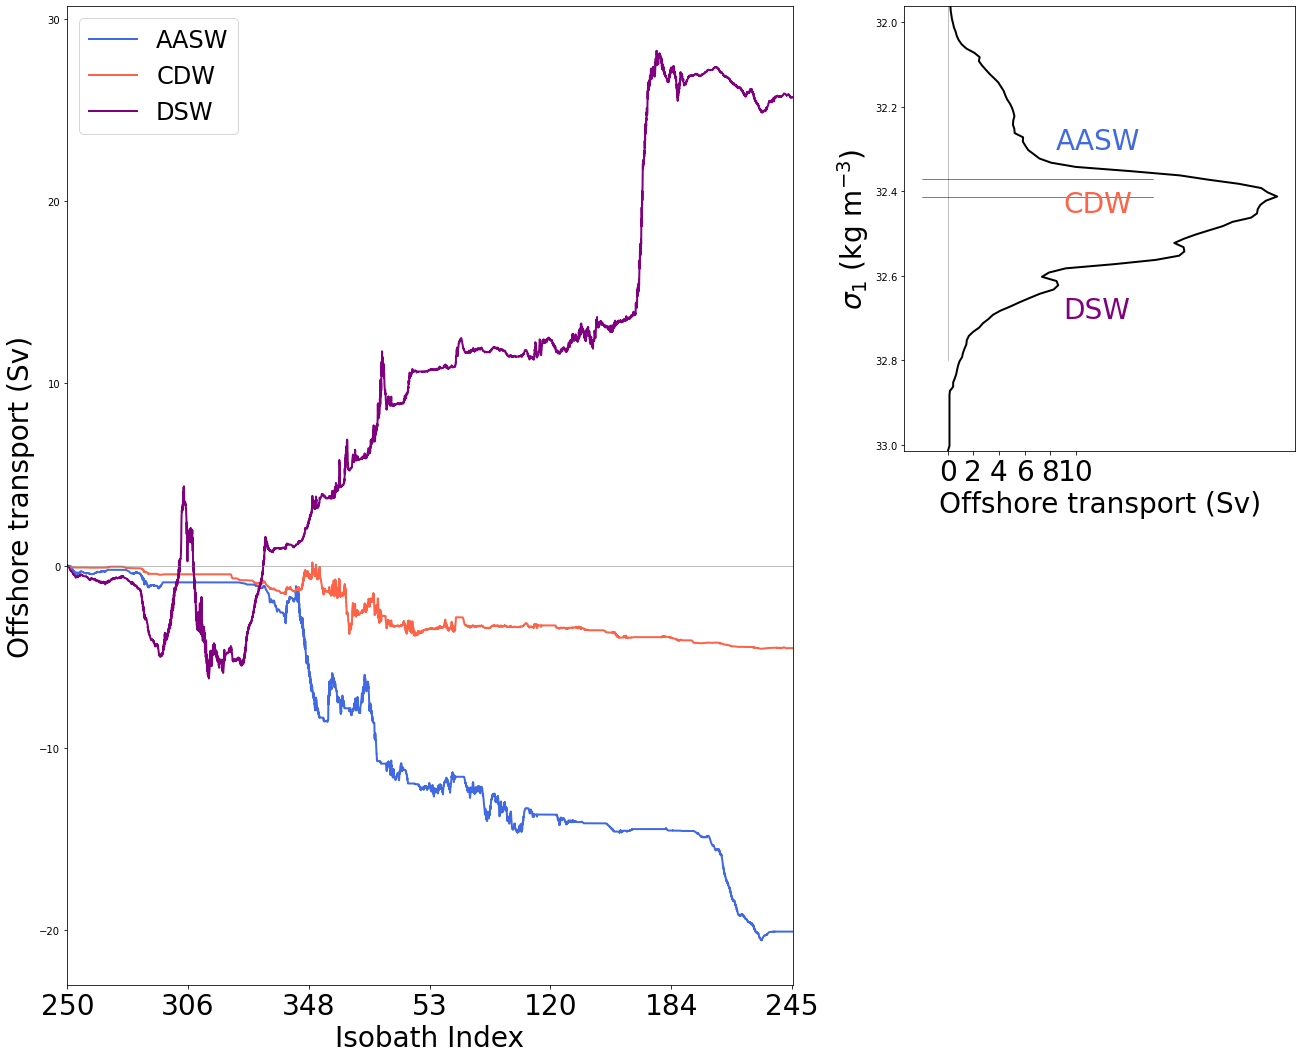

In [61]:
import cartopy.crs as ccrs
fig = plt.figure(num=1,figsize=(22,18))
gs = gridspec.GridSpec(2,2, width_ratios=[13,7]) 
ax0, ax1 = plt.subplot(gs[:,0]), plt.subplot(gs[0,1])
# gs.update(hspace = 0.4)
offshore_transport(ax0)
offshore_transport_sum(ax1)
#isobath_index_map(ax2)
plt.show()

In [53]:
def offshore_transport(ax):
    #ax.fill_between([698,1850],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)
    #ax.fill_between([3460,4300],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)
    #ax.fill_between([5524,5850],[-8.2,-8.2],[11.7,11.7], color = 'silver', alpha = 0.25)

    #ax.plot(total_trans2, color = 'k', linewidth = 1,label = 'Total')
    ax.plot(resultAASW_trans2, color = 'royalblue', linewidth = 2,label = 'AASW')
    ax.plot(resultCDW_trans2, color = 'tomato', linewidth = 2,label = 'CDW')
    ax.plot(resultDSW_trans2, color = 'purple', linewidth = 2,label = 'DSW')

    ax.set_ylabel('Offshore transport (Sv)', fontsize = 28)
    ax.set_xlabel('Isobath Index', fontsize = 28)
    ax.plot([0,contour_index_array[-1]],[0,0],'gray',linewidth=0.5)


    ax.set_xlim((0,contour_index_array[-1]))
    #ax.set_yticks([-8,-6,-4,-2,0,2,4,6,8,10])
    #ax.set_ylim((-8.2,11.2))
    ax.legend(loc=2, fontsize = 24)
    ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
    ax.set_xticklabels(['250','306','348','53','120','184','245'], fontsize = 28)

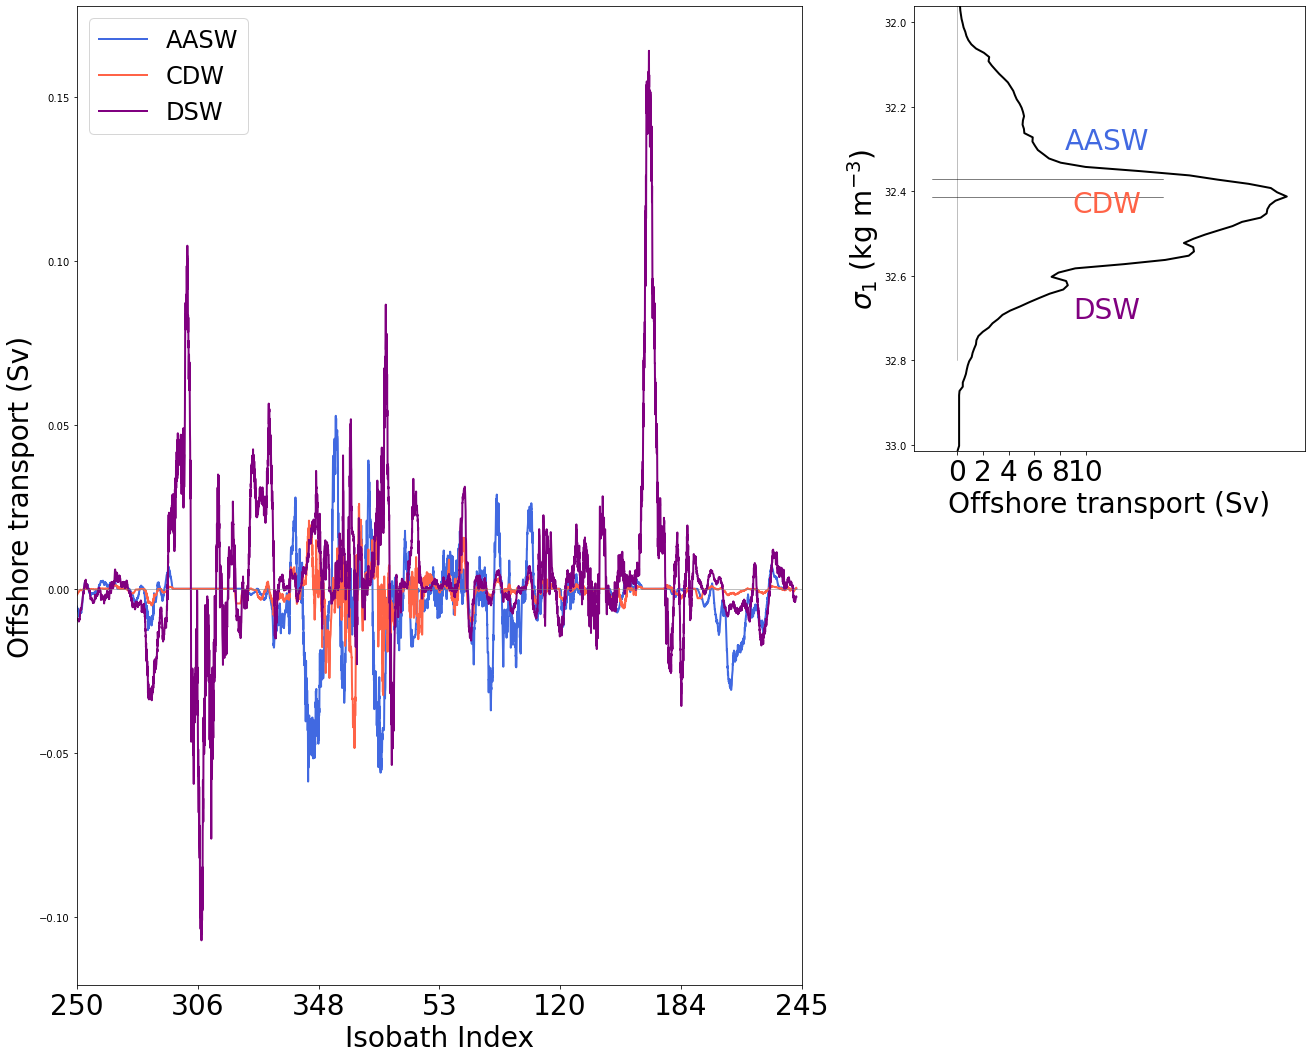

In [57]:
import cartopy.crs as ccrs
fig = plt.figure(num=1,figsize=(22,18))
gs = gridspec.GridSpec(2,2, width_ratios=[13,7]) 
ax0, ax1 = plt.subplot(gs[:,0]), plt.subplot(gs[0,1])
# gs.update(hspace = 0.4)
offshore_transport(ax0)
offshore_transport_sum(ax1)
#isobath_index_map(ax2)
plt.show()